# Project01: CNN on MNIST


## Imports

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [4]:
tf.__version__

'0.11.0rc1'

## Configuration of Neural Network



In [5]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

## Inspecting the data

The MNIST data-set is about 12 MB.

In [6]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)


Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


### Further data information

- 70.000 images with class labels

- is already split into training, test and validation set

- let us use the trainings and test set only

- class labels are in format one-hot encoding

In [7]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


![]('./images/supervised_workflow.svg')

### It may be helpful to have both one-hot as well as single number encoding!

In [8]:
# use argmax for getting the one-hot position
data.train.cls = np.argmax(data.train.labels, axis=1)
data.test.cls = np.argmax(data.test.labels, axis=1)

print data.test.cls[:10]
print data.test.labels[:10]

[7 2 1 0 4 1 4 9 5 9]
[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


In [9]:
# get the number of each digit
print 'Train data'  
for _ in range(10):
    print _, sum(data.train.cls==_)

print 40*'-'
print 'Test data'    
for _ in range(10):
    print _, sum(data.test.cls==_)

Train data
0 5444
1 6179
2 5470
3 5638
4 5307
5 4987
6 5417
7 5715
8 5389
9 5454
----------------------------------------
Test data
0 980
1 1135
2 1032
3 1010
4 982
5 892
6 958
7 1028
8 974
9 1009


### Plot some MNIST just to explore some data

7


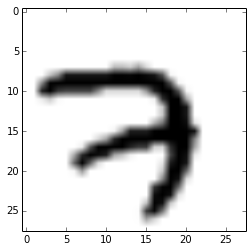

In [10]:
# image size
img_size = 28

# flat size as vector
img_size_flat = img_size * img_size

seven = data.train.images[0]
seven = seven.reshape(img_size,img_size)

plt.imshow(seven,cmap="Greys")

print data.train.cls[0]

7


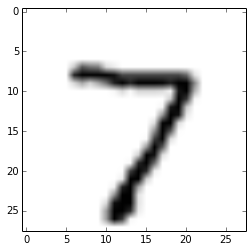

In [11]:
seven = data.test.images[0]#
seven = seven.reshape(img_size,img_size)

plt.imshow(seven,cmap="Greys")

print data.test.cls[0]

## Further data related parameters

In [12]:


# image tuple
img_shape = (img_size, img_size)

# Number of colour channels
num_channels = 1

# Number of classes
num_classes = 10

### Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [13]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

### Plot a few images to see if data is correct

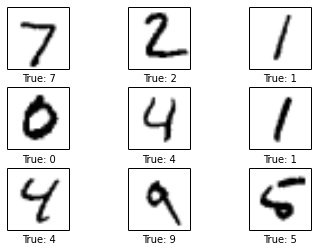

In [14]:
images = data.test.images[0:9]

cls_true = data.test.cls[0:9]

plot_images(images=images, cls_true=cls_true)

## TensorFlow Graph

- The entire purpose of TensorFlow computational graph 

- Python e.g. would know only a single numpy operation at a given time. TF knows the full computations needed

- Especially imortant: gradient of the entire graph can be calculated using the chain-rule for derivatives



## Defining a CNN architecture

In [15]:
def variable_summaries(var, name):
    """Attach a lot of summaries to a Tensor."""
    with tf.name_scope('summaries'):
        with tf.name_scope(name):
            mean = tf.reduce_mean(var)
            tf.scalar_summary('mean/' + name, mean)
            with tf.name_scope('stddev'):
                stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
            tf.scalar_summary('stddev/' + name, stddev)
            tf.scalar_summary('max/' + name, tf.reduce_max(var))
            tf.scalar_summary('min/' + name, tf.reduce_min(var))
            tf.histogram_summary(name, var)

In [16]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [17]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

### Convolutional Layer

In [18]:
def new_conv_layer(input,           
                   num_input_channels, 
                   filter_size,     
                   num_filters,        
                   use_pooling=True):  

    shape = [filter_size, filter_size, num_input_channels, num_filters]

    weights = new_weights(shape=shape)

    biases = new_biases(length=num_filters)

    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    layer += biases

    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    layer = tf.nn.relu(layer)
    return layer, weights

In [19]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()

    num_features = layer_shape[1:4].num_elements()
    
    layer_flat = tf.reshape(layer, [-1, num_features])

    return layer_flat, num_features

### Helper-function for creating a new Fully-Connected Layer

In [20]:
def new_fc_layer(input,         
                 num_inputs,     
                 num_outputs,    
                 use_relu=True): 
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    layer = tf.matmul(input, weights) + biases

    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

### Placeholder variables

In [21]:
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

In [22]:
with tf.name_scope('input_image'):
    x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [23]:
with tf.name_scope('true_label'):
    y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')
    y_true_cls = tf.argmax(y_true, dimension=1)

### Convolutional Layer 1


In [24]:
with tf.name_scope('Conv1'):
    layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

In [25]:
layer_conv1

<tf.Tensor 'Conv1/Relu:0' shape=(?, 14, 14, 16) dtype=float32>

### Convolutional Layer 2

In [26]:
with tf.name_scope('Conv2'):
    layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

In [27]:
layer_conv2

<tf.Tensor 'Conv2/Relu:0' shape=(?, 7, 7, 36) dtype=float32>

### Flatten Layer


In [28]:
with tf.name_scope('flatten_layer'):
    layer_flat, num_features = flatten_layer(layer_conv2)

In [29]:
layer_flat

<tf.Tensor 'flatten_layer/Reshape:0' shape=(?, 1764) dtype=float32>

In [30]:
num_features

1764

### Fully-Connected Layer 1

In [31]:
with tf.name_scope('fc_1'):
    layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [32]:
layer_fc1

<tf.Tensor 'fc_1/Relu:0' shape=(?, 128) dtype=float32>

### Fully-Connected Layer 2


In [33]:
with tf.name_scope('fc_2'):
    layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)
    y_pred = tf.nn.softmax(layer_fc2)

In [34]:
layer_fc2

<tf.Tensor 'fc_2/add:0' shape=(?, 10) dtype=float32>

### Cost-function to be optimized

In [35]:
with tf.name_scope('cross_entropy'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
    cost = tf.reduce_mean(cross_entropy)
    y_pred_cls = tf.argmax(y_pred, dimension=1)
    correct_prediction = tf.equal(y_pred_cls, y_true_cls)

### Optimization Method

In [36]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [37]:
with tf.name_scope('final_accuracy'):
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

### Create TensorFlow session

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [38]:
session = tf.Session()

tf.summary.scalar('loss', cost)
tf.summary.scalar('accuracy', accuracy)
    
merged = tf.merge_all_summaries()
#writer = tf.train.SummaryWriter('./logs/',session.graph)

In [39]:
#writer = tf.train.SummaryWriter("logs/", session.graph)
session.run(tf.initialize_all_variables())

### Helper-function to perform optimization iterations

In [40]:
train_batch_size = 64

In [41]:
total_iterations = 0



def optimize(num_iterations):
    global total_iterations
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        session.run(optimizer, feed_dict=feed_dict_train)
        writer = tf.train.SummaryWriter("./logs", graph=tf.get_default_graph())
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            summary,_ = session.run([merged, accuracy] , feed_dict=feed_dict_train)
            writer.add_summary(summary, i)
            writer.flush()
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

    total_iterations += num_iterations
    end_time = time.time()

    time_dif = end_time - start_time
    #print "Time usage: " + str(timedelta(seconds=int(round(time_dif)))) 

### Helper-function to plot example errors

In [42]:
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    
    images = data.test.images[incorrect]
    
    cls_pred = cls_pred[incorrect]

    cls_true = data.test.cls[incorrect]
    
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper-function to plot confusion matrix

In [43]:
def plot_confusion_matrix(cls_pred):
    cls_true = data.test.cls
    
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    print(cm)
    plt.matshow(cm)

    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.show()

### Helper-function for showing the performance

In [44]:
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    num_test = len(data.test.images)

    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test)
        images = data.test.images[i:j, :]

        labels = data.test.labels[i:j, :]
        feed_dict = {x: images,
                     y_true: labels}
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j


    cls_true = data.test.cls

    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_test
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print msg.format(acc, correct_sum, num_test)

    if show_example_errors:
        print "Example errors:"
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    if show_confusion_matrix:
        print "Confusion Matrix:"
        plot_confusion_matrix(cls_pred=cls_pred)

In [60]:
optimize(num_iterations=1000) # We already performed 1 iteration above.

The history saving thread hit an unexpected error (OperationalError('unable to open database file',)).History will not be written to the database.
Accuracy on Test-Set: 92.8% (9277 / 10000)
Example errors:


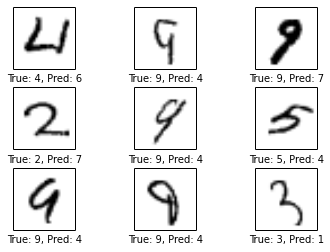

In [61]:
print_test_accuracy(show_example_errors=True)

### Helper-function for plotting convolutional weights

In [47]:
def plot_conv_weights(weights, input_channel=0):
    w = session.run(weights)

    w_min = np.min(w)
    w_max = np.max(w)

    num_filters = w.shape[3]

    num_grids = int(math.ceil(math.sqrt(num_filters)))

    fig, axes = plt.subplots(num_grids, num_grids)

    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            img = w[:, :, input_channel, i]

            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

### Helper-function for plotting the output of a convolutional layer

In [48]:
def plot_conv_layer(layer, image):
    feed_dict = {x: [image]}

    values = session.run(layer, feed_dict=feed_dict)

    num_filters = values.shape[3]

    num_grids = int(math.ceil(math.sqrt(num_filters)))
    
    fig, axes = plt.subplots(num_grids, num_grids)

    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            img = values[0, :, :, i]
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

### Input Images

In [49]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

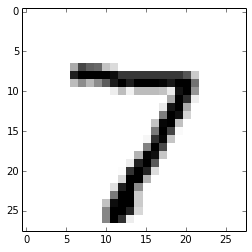

In [50]:
image1 = data.test.images[0]
plot_image(image1)

Plot another example image from the test-set.

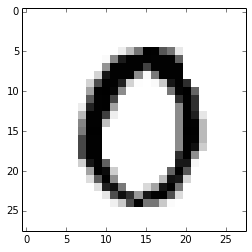

In [51]:
image2 = data.test.images[13]
plot_image(image2)

### Convolution Layer 1

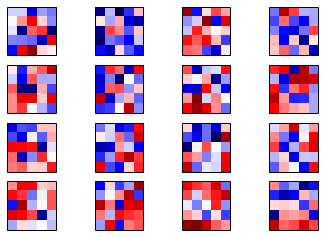

In [52]:
plot_conv_weights(weights=weights_conv1)

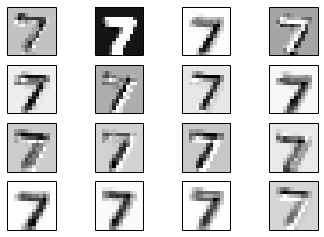

In [53]:
plot_conv_layer(layer=layer_conv1, image=image1)

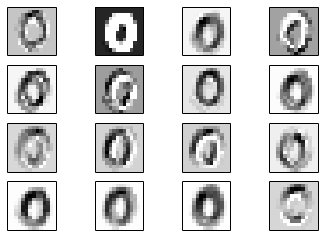

In [54]:
plot_conv_layer(layer=layer_conv1, image=image2)

### Convolution Layer 2

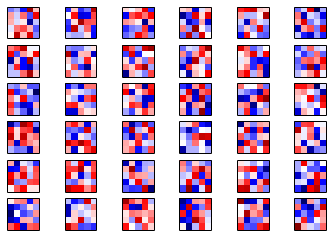

In [55]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

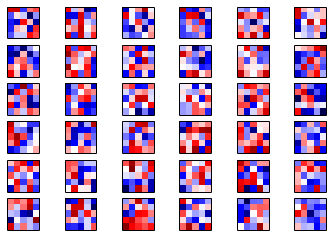

In [56]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

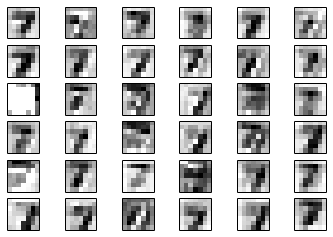

In [57]:
plot_conv_layer(layer=layer_conv2, image=image1)

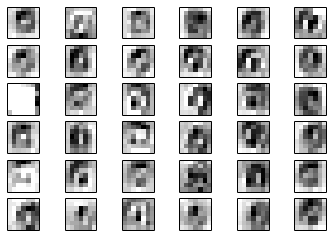

In [58]:
plot_conv_layer(layer=layer_conv2, image=image2)

### Close TensorFlow Session

In [59]:
# session.close()